In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit

Functions & defs

In [7]:
def ode_demo(y,t,b,g,m):
    """
    Differential equation of a SIR model with equal birth and deathrate.
    
    Arguments:
    y -- 
    t -- time index (days)
    b -- beta parameter (infectiousness)
    g -- gamma parameter (recovery rate)
    m -- mu parameter (birth and deathrate)
    """
    s,i,r = y
    dsdt = m - b * s * i - m * s
    didt = b * s * i - g * i - m * i
    drdt = g * i - m * r
    
    return dsdt, didt, drdt


def SIR_events(S,I,R,p):
    
    extinctions = 0
    # Death S
    if p == 0:
        S.append(S[-1] - 1 + 1)
        I.append(I[-1])
        R.append(R[-1])
    
    # Infection
    elif p == 1:
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])
        
    # Death I
    elif p == 2:
        S.append(S[-1] + 1)
        I.append(I[-1] - 1)
        R.append(R[-1])
        
        # extinctions
        if I[-1] < 1:
            extinctions = 1
    
    # Recovered
    elif p == 3:
        S.append(S[-1])
        I.append(I[-1] - 1)
        R.append(R[-1] + 1)
        
        # extinctions
        if I[-1] < 1:
            extinctions = 1
    
    # Death R
    elif p == 4:
        S.append(S[-1] + 1)
        I.append(I[-1])
        R.append(R[-1] - 1)
        
    # Import
    elif p == 5:
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])
        
    return S, I, R, extinctions
    
        
def SIR_demo(n, max_t, beta, gamma, mu):
    S = [0.99*n]
    I = [0.01*n]
    R = [0]
    t = [0]

    while t[-1] < max_t:
        # Set rates
        rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
                mu * I[-1], gamma * I[-1],  # rate(I)
                mu * R[-1]]  # rate(R)

        rates_sum = sum(rates)
        dt = -1*np.log(np.random.random()) / rates_sum
        t.append(t[-1] + dt)

        rand = np.random.random()
        
        p = 0
        for i in range(len(rates)):
            if rand * rates_sum < sum(rates[:i+1]):
                p = i
                break
        
        S, I, R, e = SIR_events(S,I,R,p)

    return S, I, R, t


def SIR_import(n, max_t, beta, gamma, mu, epsilon):
    S = [n]
    I = [0]
    R = [0]
    t = [0]
    extinctions = 0

    while t[-1] < max_t:
        # Set rates
        rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
                mu * I[-1], gamma * I[-1],  # rate(I)
                mu * R[-1],  # rate(R)
                epsilon * S[-1]] # Import

        rates_sum = sum(rates)
        dt = -1*np.log(np.random.random()) / rates_sum
        t.append(t[-1] + dt)

        rand = np.random.random()
        
        p = 0
        for i in range(len(rates)):
            if rand * rates_sum < sum(rates[:i+1]):
                p = i
                break
                
        S, I, R, e = SIR_events(S,I,R,p)
        extinctions += e

    return S, I, R, t, extinctions

Hallmark: Variability

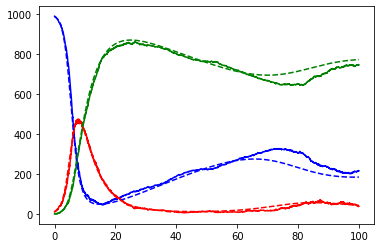

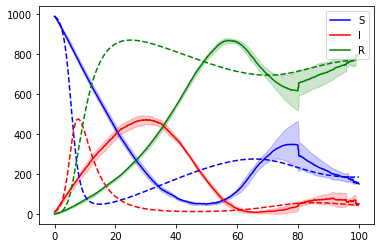

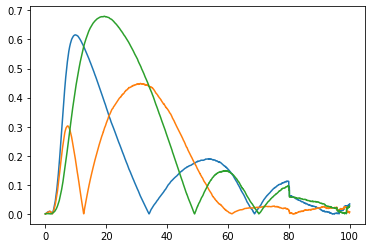

In [8]:
beta = 1.0
gamma = 0.2
mu = 0.01
population = 1000
max_t = 100

s, i, r, t = SIR_demo(population, max_t, beta, gamma, mu)

# Integrate ODE using odeint
time = np.linspace(0, max_t, max_t*10)
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T

plt.figure()
plt.plot(t, s, color='b')
plt.plot(t, i, color='r')
plt.plot(t, r, color='g')
plt.plot(time, s_ode*population, color='b', linestyle='--')
plt.plot(time, i_ode*population, color='r', linestyle='--')
plt.plot(time, r_ode*population, color='g', linestyle='--')
# plt.ylim(-0.05 * population,1.05 * population)
plt.show()

#####
### IK DENK DAT DIT FOUT GAAT OMDAT WE ER VAN UIT GAAN DAT ALLE TIJDSSTAPPEN GELIJK ZIJN
#####
for i in range(10): #Todo: hoger?
    S, I, R, T = SIR_demo(population, max_t, beta, gamma, mu)
    if i == 0:
        data_S = {'Srun0': S}
        data_I = {'Irun0': I}
        data_R = {'Rrun0': R}
        data_T = {'Trun0': T}
        dfS = pd.DataFrame(data_S)
        dfI = pd.DataFrame(data_I)
        dfR = pd.DataFrame(data_R)
        dfT = pd.DataFrame(data_T)
    elif i != 0:
        temp_dfS = pd.DataFrame({f'Srun{i}': S})
        dfS = pd.concat([dfS, temp_dfS], axis=1)
        temp_dfI = pd.DataFrame({f'Irun{i}': I})
        dfI = pd.concat([dfI, temp_dfI], axis=1)
        temp_dfR = pd.DataFrame({f'Rrun{i}': R})
        dfR = pd.concat([dfR, temp_dfR], axis=1)
        temp_dfT = pd.DataFrame({f'Trun{i}': T})
        dfT = pd.concat([dfT, temp_dfT], axis=1)

# index = 0
# timesteps = 0.01 * max_t
# current_time = 0
# meanS = []
# meanI = []
# meanR = []
# while len(current_S < max_t):
#     current_S = dfS.mean(axis=1, skipna=True)[index]
#     print(current_S)
#     current_I = dfI.mean(axis=1, skipna=True)[index]
#     current_R = dfR.mean(axis=1, skipna=True)[index]
#     meanS.appen(current_S)
#     meanI.appen(current_I)
#     meanR.appen(current_R)
    
#     if current_time > timesteps:
#         current_time = 0
#         mean_S.append(current_S)
#         mean_I.append(current_I)
#         mean_R.append(current_R)
#         current_S = 0
#         current_I = 0
#         current_R = 0
#     else:
#         current_time += 

# def scale_time(df, dft, max_t):
#     data = []
#     timesteps = max_t * 0.01
#     current_time = 0
#     index = 0
#     while 
    
        
meanS = dfS.mean(axis=1, skipna=True)
stdS = dfS.std(axis=1, skipna=True)
meanI = dfI.mean(axis=1, skipna=True)
stdI = dfI.std(axis=1, skipna=True)
meanR = dfR.mean(axis=1, skipna=True)
stdR = dfR.std(axis=1, skipna=True)

time = np.linspace(0, max_t, len(meanI))
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T

plt.figure()
plt.plot(time,meanS, label='S', color='b')
plt.plot(time,meanI, label='I', color='r')
plt.plot(time,meanR, label='R', color='g')
plt.plot(time,s_ode*population, color='b', linestyle='--')
plt.plot(time,i_ode*population, color='r', linestyle='--')
plt.plot(time,r_ode*population, color='g', linestyle='--')

plt.fill_between(time, meanS - stdS, meanS + stdS,
                      color='b', alpha=0.2)
plt.fill_between(time, meanI - stdI, meanI + stdI,
                      color='r', alpha=0.2)
plt.fill_between(time, meanR - stdR, meanR + stdR,
                      color='g', alpha=0.2)

plt.legend(loc=1)
plt.show()

plt.figure()
plt.plot(time,np.abs(meanS - s_ode*population)/population)
plt.plot(time,np.abs(meanI - i_ode*population)/population)
plt.plot(time,np.abs(meanR - r_ode*population)/population)
plt.show()


Hallmark: necative (co)-variances

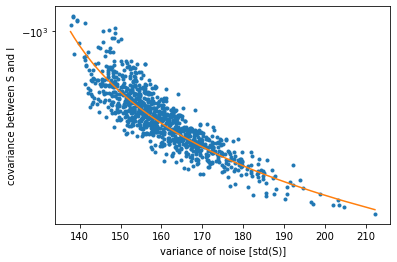

In [10]:
beta = 2
gamma = 0.5
mu = 0.1
population = 1000
max_t = 60
epsilon = 5.5 * 10 ** (-5) * np.sqrt(population)
covlist= []
noiselist = []


for i in range(1000):
    S, I, R, T, Ext = SIR_import(population, max_t, beta, gamma, mu, epsilon)
    cov = np.cov(S, I)[0, 1]
    covlist.append(cov)
    noise = np.std(S)
    noiselist.append(noise)


m, b = np.polyfit(noiselist, covlist, 1)  # fit line through data

x = np.sort(np.array(noiselist))

plt.figure()
plt.plot(noiselist, covlist, '.')
plt.plot(x, m*x+b)
#plt.xscale('symlog')
plt.yscale('symlog', linthresh=0.01)
#plt.ylim(np.min(covlist)*1.5, 0)
plt.xlabel('variance of noise [std(S)]')
plt.ylabel('covariance between S and I')
plt.show()

Extinctions

C:\Users\larsg\AppData\Local\Temp/ipykernel_10340/3027968285.py:108: RuntimeWarning: invalid value encountered in double_scalars
  rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
C:\Users\larsg\AppData\Local\Temp/ipykernel_10340/1477948135.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)


Text(0, 0.5, 'mean number of extinctions per ...')

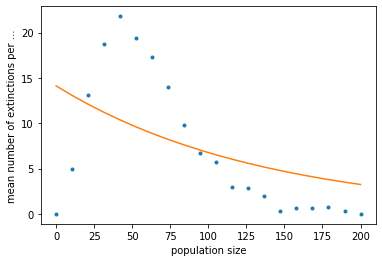

In [14]:
def fit_function(x, a, b):
    return a*np.exp(-b*x)


beta = 1.48
gamma = 0.14
mu = 0.02
population = np.linspace(0, 200, 20)
max_t = 3600
ext_list_mean = []

for pop in population:
    ext_list = []
    for i in range(10):
        epsilon = 5.5 * 10 ** (-5) * np.sqrt(pop)
        S, I, R, T, Ext = SIR_import(pop, max_t, beta, gamma, mu, epsilon)
        ext_list.append(Ext)
    ext_list_mean.append(np.mean(ext_list))

popt, pcov = curve_fit(fit_function, np.array(population), np.array(ext_list_mean))

fitted = fit_function(np.array(population), popt[0], popt[1])

plt.figure()
plt.plot(population, ext_list_mean, '.')
plt.plot(population, fitted)
plt.xlabel("population size")
plt.ylabel("mean number of extinctions per ...")


Increased transcients, --> plotjes hardcode gaat dus ergens nog iets fout

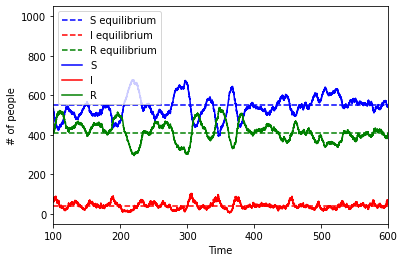

In [17]:
beta = 1
gamma = 0.5
mu = 0.05
population = 1000
max_t = 600
epsilon = 5.5 * 10 ** -5 * np.sqrt(population)

s, i, r, t, e = SIR_import(population, max_t, beta, gamma, mu, epsilon)


R0 = beta/(gamma+mu)
Seq = 1/R0
Ieq = (gamma/beta )* (R0-1)
Req = 1 - Seq - Ieq


plt.figure()
plt.axhline(y=Seq*population, color='b', linestyle='--', label='S equilibrium')
plt.axhline(y=Req*population, color='r', linestyle='--', label='I equilibrium')
plt.axhline(y=Ieq*population, color='g', linestyle='--', label='R equilibrium')
plt.xlim([100, max_t])
plt.plot(t, s, color='b', label='S')
plt.plot(t, i, color='r', label='I')
plt.plot(t, r, color='g', label='R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('# of people')
plt.show()

Stochastic Resonance

In [ ]:
beta = 9
gamma = 3
mu = 3/50
population = 100
max_t = 400
epsilon = 5.5 * 10 ** -5 * np.sqrt(population)

# Integrate ODE using odeint
time = np.linspace(0, max_t, max_t*2)
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T
s_ode *= population
i_ode *= population
r_ode *= population

s, i, r, t, e = SIR_import(population, max_t, beta, gamma, mu, epsilon)

f, (ax1, ax2, ax3) = plt.subplots(3,1)
ax1.plot(time, s_ode, '--', color='b')
ax1.plot(t, s, color='b')
ax1.set_xticks(np.arange(0, max_t, 25))
ax1.grid(axis='both')
ax1.set_xlim(([20, max_t]))

ax2.plot(time, i_ode, '--', color='r')
ax2.plot(t, i, color='r')
ax2.set_xticks(np.arange(0, max_t, 25))
ax2.grid(axis='both')
ax2.set_xlim(([20, max_t]))

ax3.plot(time, r_ode, '--', color='g')
ax3.plot(t, r, color='g')
ax3.set_xticks(np.arange(0, max_t, 25))
ax3.grid(axis='both')
ax3.set_xlim(([20, max_t]))

plt.show()

i_ode = np.array(i_ode)
Ipower = fft(i_ode[2:])
Ipower = abs(Ipower)
xf = fftfreq(i_ode[2:].size, d=(time[1]-t[0]))
xf = abs(xf)


plt.figure()
plt.xlabel('Frequency [1/day]')
plt.ylabel('Amplitude [A.U.]')
plt.title('Periodic analysis of fraction infected ODE')
plt.plot(xf, Ipower)
plt.xlim([0.02, .5])
plt.ylim([0, 150])
plt.xticks(np.arange(0, 0.5, 0.05))
plt.grid(axis='both')
plt.show()
